# Stochastic Hill Climber

Using this search-based black-box test, we aim to automatically find adversarial samples for detecting potential model biases.

In [255]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
from skl2onnx.common.data_types import FloatTensorType
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

### Load the synthetic dataset

In [3]:
# Let's load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

# Let's specify the features and the target
y = data['checked']
X = data.drop(['checked'], axis=1)
X = X.astype(np.float32)

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Print size of train and test
print(X_train.shape, X_test.shape)
print(type(X_train), type(X_test))
print(type(y_train), type(y_test))

def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue

        t = FloatTensorType([None, 1])

        inputs.append((k, t))
    return inputs


initial_inputs = convert_dataframe_schema(X_train)


inputs = {c: X_test[c].values for c in X_test.columns}
for (c, _) in initial_inputs:
    inputs[c] = inputs[c].astype(np.float32)
for k in inputs:
    inputs[k] = inputs[k].reshape((inputs[k].shape[0], 1))

print(type(initial_inputs))
print(type(inputs))
print(inputs.keys())


(9483, 315) (3162, 315)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
<class 'list'>
<class 'dict'>
dict_keys(['adres_aantal_brp_adres', 'adres_aantal_verschillende_wijken', 'adres_aantal_verzendadres', 'adres_aantal_woonadres_handmatig', 'adres_dagen_op_adres', 'adres_recentst_onderdeel_rdam', 'adres_recentste_buurt_groot_ijsselmonde', 'adres_recentste_buurt_nieuwe_westen', 'adres_recentste_buurt_other', 'adres_recentste_buurt_oude_noorden', 'adres_recentste_buurt_vreewijk', 'adres_recentste_plaats_other', 'adres_recentste_plaats_rotterdam', 'adres_recentste_wijk_charlois', 'adres_recentste_wijk_delfshaven', 'adres_recentste_wijk_feijenoord', 'adres_recentste_wijk_ijsselmonde', 'adres_recentste_wijk_kralingen_c', 'adres_recentste_wijk_noord', 'adres_recentste_wijk_other', 'adres_recentste_wijk_prins_alexa', 'adres_recentste_wijk_stadscentru', 'adres_unieke_wijk_ratio', 'afspraak_aanme

### Stochastic Hill Climber Algorithm

First we manually define a set of features to consider when applying pertubations to obtain neighbours, based on the hints given.
Note that despite the fact we are manually defining these, the differences with metamorphic testing are:
- Rather than considering the total accuracies, we now look at *confidence* values for individual samples in order to locate potential biases on a more fine-grained level
- Based on these confidence levels obtained on artificial neighbour samples, we apply search-based heuristics i.e. evaluate fitness function in order to eventually locate the "best" adversarial example

Eventually when we have obtained the best (artificially created) adversarial example, we will assess its profile and compare it to real data for which the model performs "ok".

In [342]:
# For auditing model 1
age_features = ['persoon_leeftijd_bij_onderzoek']

# For auditing model 2: note that these are all bools
ethnicity_features = [ 'persoonlijke_eigenschappen_spreektaal_anders',
                        'persoonlijke_eigenschappen_nl_schrijvenfalse',
                        'contacten_onderwerp_boolean_taaleis___voldoet',
                        'afspraak_afgelopen_jaar_ontheffing_taaleis',
                        'belemmering_hist_taal']

ethnicity_features_en = ['diff_lang', 'nl_writing_false', 'lang_reqs_met', 'appointment_lang', 'obstacle_lang']

print(len(ethnicity_features))

# Let's print some feature values in test set 
# print(data['persoon_leeftijd_bij_onderzoek'].value_counts())
# print(data['persoonlijke_eigenschappen_taaleis_voldaan'].value_counts())
# print(data['contacten_onderwerp_beoordelen_taaleis'].value_counts())    # NOTE: has values in {0, 1, 2, 3, 4}
# print(data['afspraak_afgelopen_jaar_ontheffing_taaleis'].value_counts())
# print(data['belemmering_hist_taal'].value_counts())

5


### Load the model

In [414]:
# Let's load the model
new_session1 = rt.InferenceSession("model/model_1_external.onnx")

# Let's predict the target
y_pred_onnx =  new_session1.run(None, inputs)
accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

# Get model confidence for random test sample
model_confs_test = y_pred_onnx[1]
print(f"{len(model_confs_test)} confidence pairs on test data: {model_confs_test}")

Accuracy of the ONNX model:  0.9228336495888678
3162 confidence pairs on test data: [{0: 1.0, 1: -5.960464477539063e-08}, {0: 0.006379604339599609, 1: 0.9936203956604004}, {0: 0.9977443218231201, 1: 0.002255648374557495}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 0.969210147857666, 1: 0.030789852142333984}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 0.9999980926513672, 1: 1.9371509552001953e-06}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 0.9999998807907104, 1: 8.940696716308594e-08}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 0.9999995827674866, 1: 4.172325134277344e-07}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 0.9974170923233032, 1: 0.0025829076766967773}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 1.

In [119]:

def get_age_neighbours(X_test_sample, y_test_sample, age_features):
    # Initialize artificial test set containing 1 random test sample in X_test
    X_test_neighbours = []
    for feat in age_features:
        n1, n2, n3, n4, n5, n6 = X_test_sample.copy(), X_test_sample.copy(), X_test_sample.copy(), X_test_sample.copy(), X_test_sample.copy(), X_test_sample.copy()
        og_feature_value = X_test_sample[feat].values[0]
        n1[feat] = max(0, min(100, og_feature_value + np.random.randint(-5, 0)))  
        n2[feat] = max(0, min(100, og_feature_value + np.random.randint(0, 5)))
        n3[feat] = max(0, min(100, og_feature_value + np.random.randint(-10, 0))) 
        n4[feat] = max(0, min(100, og_feature_value + np.random.randint(0, 10))) 
        n5[feat] = max(0, min(100, og_feature_value + np.random.randint(-15, 0))) 
        n6[feat] = max(0, min(100, og_feature_value + np.random.randint(0, 15))) 
        # Add neighbours to artificial test set
        X_test_neighbours.extend([n1, n2, n3, n4, n5, n6])

    # Create corresponding artificial y_test - NOTE that all labels of neighbours should be same as original sample!
    # i.e. it's just a list of the original label repeated n_neighbours times
    y_test_neighbours = [y_test_sample] * len(X_test_neighbours)

    # print(f"Type of X_test_neighbours: {type(X_test_neighbours)}")
    # print(f"Type of y_test_neighbours: {type(y_test_neighbours)}")
    
    return X_test_neighbours, y_test_neighbours

In [392]:
def get_ethnicity_neighbours(X_test_sample, y_test_sample, ethnicity_features):
    # print(f"No. of ethnicity features: {len(ethnicity_features)}")
    X_test_neighbours = []
    n_feat = len(ethnicity_features)   # This is the no. of neighbours we create
    for feat in ethnicity_features:
        neigh = X_test_sample.copy()
        # For curr feature, flip the bool
        neigh[feat] = not neigh[feat].values[0]
        X_test_neighbours.append(neigh)
        
    y_test_neighbours = [y_test_sample] * len(X_test_neighbours)
    # print(f"Type of X_test_neighbours: {type(X_test_neighbours)}")
    return X_test_neighbours, y_test_neighbours

In [189]:
def convert_df_to_dict(new_test_X):
    new_X_list = convert_dataframe_schema(new_test_X)

    new_X_dict = {c: new_test_X[c].values for c in new_test_X.columns}
    for (c, _) in new_X_list:
        new_X_dict[c] = new_X_dict[c].astype(np.float32)
    for k in inputs:
        new_X_dict[k] = new_X_dict[k].reshape((new_X_dict[k].shape[0], 1))
    return new_X_dict

In [190]:
def compute_fitness(conf_pairs_list, og_output_label):
    # TODO get rid of og label
    fitness = []
    rank1_key, rank2_key = None, None
    for i, conf_pair in enumerate(conf_pairs_list):
        # For the first one (curr), we always subtract P_1 - P_2
        if i == 0:
            rank1_key = max(conf_pair, key=conf_pair.get)
            rank2_key = min(conf_pair, key=conf_pair.get)
            # Round to 3 decimal places
            val = round(conf_pair[rank1_key] - conf_pair[rank2_key], 3)
            fitness.append(val)
            continue
        # For the neighbours, check if model output has changed or not
        neigh_rank1_key = max(conf_pair, key=conf_pair.get)
        neigh_rank2_key = min(conf_pair, key=conf_pair.get)
        if neigh_rank1_key != rank1_key:
            val = round(-conf_pair[neigh_rank1_key], 3)   # Negative prob for the new output label
        else:
            val = round(conf_pair[neigh_rank1_key] - conf_pair[neigh_rank2_key], 3)
        fitness.append(val)
    return fitness

In [391]:
def get_neighbours_fitness(random_test_X, random_test_y):
    # 2. Create neigbouring samples by perturbing values of single features
    # TODO: set to correct feature set
    # neighs_X, neighs_y = get_age_neighbours(random_test_X, random_test_y, age_features)
    neighs_X, neighs_y = get_ethnicity_neighbours(random_test_X, random_test_y, ethnicity_features)
    # print(f"Original age: {random_test_X['persoon_leeftijd_bij_onderzoek'].values[0]}")
    # print(f"New ages of neighbours: {neighs_X[0]['persoon_leeftijd_bij_onderzoek'].values[0], neighs_X[1]['persoon_leeftijd_bij_onderzoek'].values[0], neighs_X[2]['persoon_leeftijd_bij_onderzoek'].values[0], neighs_X[3]['persoon_leeftijd_bij_onderzoek'].values[0], neighs_X[4]['persoon_leeftijd_bij_onderzoek'].values[0], neighs_X[5]['persoon_leeftijd_bij_onderzoek'].values[0]}")
    new_test_X = random_test_X._append(neighs_X)             # Type: pandas.core.frame.DataFrame
    new_test_y = random_test_y._append(pd.Series(neighs_y))  # Type: pandas.core.series.Series

    # 3. Take the best solution and start from 1 again, by computing fitness function
    new_X_dict = convert_df_to_dict(new_test_X)
    y_pred_1 =  new_session1.run(None, new_X_dict)

    model_confs_test = y_pred_1[1]
    print(f"{len(model_confs_test)} confidence pairs on test data: {model_confs_test}")
    fitness_vals = compute_fitness(model_confs_test, random_test_y.values[0])
    print(f"Fitness values: {fitness_vals}")
    
    return new_test_X, new_test_y, fitness_vals


### Hill Climber Loop for Age Features

In [ ]:
eps = 0.001    # TODO: possibly add eps
patience = 50  # If fitness value of neighbours is not WORSE than current solution for patience iterations, stop
count = 0
max_iter = 500

# TODO: Sample a random test sample from test set for which checked = 1
random_test_X = X_test.sample(n=1)
random_test_y = y_test[random_test_X.index]
print(type(random_test_X), random_test_X.shape, type(random_test_y), random_test_y.shape)
print(f"Random test sample has og label {random_test_y.values[0]}")

best_neigh_X = random_test_X    # Current best neighbour is set to initial random test sample
best_neigh_y = random_test_y
best_fitness_vals = []   
best_fitness_ages = []       

# 4. Stopping criteria: none of the neighbours have a LOWER fitness value than the current solution (use eps)]
while True:
    count += 1
    max_iter -= 1
    print(f"\nIteration {count}")
    # 1. Start with random test sample: get model confidence for this sample
    new_test_X, new_test_y, fitness_vals = get_neighbours_fitness(best_neigh_X, best_neigh_y)
    curr_fitness = fitness_vals[0]
    best_fitness_ages.append(best_neigh_X['persoon_leeftijd_bij_onderzoek'].values[0])
    # Get indices of lowest fitness value in list
    min_fitness_idxs = [i for i, x in enumerate(fitness_vals) if x == min(fitness_vals)]
    # If none of the neighbours has a lower fitness value than the current solution, decrease patience
    if all(fitness_val >= curr_fitness for fitness_val in fitness_vals):
        print("None of the neighbours has lower fitness --- decreasing patience and picking random MIN")
        patience -= 1
        # We do pick a random sample out of all min values, to avoid getting stuck in local minima
        idx = np.random.choice(min_fitness_idxs[1:])     # TODO: idx 0 is excluded bc it gives issues
        best_neigh_X = new_test_X.iloc[idx].to_frame().transpose()
        best_neigh_y = new_test_y.iloc[idx]
    elif len(min_fitness_idxs) == 1:                            # If there is only one other min value, update best neighbour                 
        best_neigh_X = new_test_X.iloc[min_fitness_idxs[0]].to_frame().transpose()
        best_neigh_y = new_test_y.iloc[min_fitness_idxs[0]]
    else:                                                       # If there are multiple min values (incl. curr possibly), choose randomly
        idx = np.random.choice(min_fitness_idxs[1:])     # TODO: idx 0 is excluded bc it gives issues
        best_neigh_X = new_test_X.iloc[idx].to_frame().transpose()
        best_neigh_y = new_test_y.iloc[idx]
    if patience == 0 or max_iter == 0:
        break

# NOTE: we don't have labels for the artificial neighbours, but ideally the original label should not change by the pertubations

In [ ]:
print(len(best_fitness_vals), len(best_fitness_ages))

# Plot fitness values and ages against iterations (count) in one plot with legend
# sns.lineplot(x=range(1, count+1), y=best_fitness_vals, label='Fitness values of best solutions')
# NOTE: plotting fitness is not very useful, because every iteration the fitness value of curr solution 
# will be diff from the fitness value for that same solution in the previous iteration (which was relative to the curr solution!)
# So you would see lots of spikes
sns.lineplot(x=range(1, count+1), y=best_fitness_ages, label='Age').set_title('Age values of best solutions against iterations - Model 1')
sns.set_style("whitegrid")
sns.despine()
sns.set(rc={'figure.figsize':(10,6)})
sns.set_context("talk")
sns.set_palette("husl")
sns.set_style("whitegrid")
sns.set_style("ticks")

### Hill Climber Loop for Ethnicity Features

In [435]:
eps = 0.001    # TODO: possibly add eps
patience = 50  # If fitness value of neighbours is not WORSE than current solution for patience iterations, stop
count = 0
max_iter = 200

# TODO: Sample a random test sample from test set for which checked = 1
random_test_X = X_test.sample(n=1)
random_test_y = y_test[random_test_X.index]
print(type(random_test_X), random_test_X.shape, type(random_test_y), random_test_y.shape)
print(f"Random test sample has og label {random_test_y.values[0]}")

best_neigh_X = random_test_X    # Current best neighbour is set to initial random test sample
best_neigh_y = random_test_y
best_fitness_ethnic_vls = []   # 2d list of dict of 16 ethnicity values    
best_fitness_vals = []

# 4. Stopping criteria: none of the neighbours have a LOWER fitness value than the current solution (use eps)]
while True:
    count += 1
    max_iter -= 1
    print(f"\nIteration {count}")
    # 1. Start with random test sample: get model confidence for this sample
    new_test_X, new_test_y, fitness_vals = get_neighbours_fitness(best_neigh_X, best_neigh_y)
    curr_fitness = fitness_vals[0]
    
    # Create dict with keys for all ethinicity features and corresponding values, for curr best sample
    curr_ethnicity_list = []
    for feat in ethnicity_features:
        curr_ethnicity_list.append(best_neigh_X[feat].values[0])
    best_fitness_ethnic_vls.append(curr_ethnicity_list)

    # Get indices of lowest fitness value in list
    min_fitness_idxs = [i for i, x in enumerate(fitness_vals) if x == min(fitness_vals)]
    # If none of the neighbours has a lower fitness value than the current solution, decrease patience
    if all(fitness_val >= curr_fitness for fitness_val in fitness_vals):
        print("None of the neighbours has lower fitness --- decreasing patience and picking random MIN")
        patience -= 1
        # We do pick a random sample out of all min values, to avoid getting stuck in local minima
        idx = np.random.choice(min_fitness_idxs[1:])     # TODO: idx 0 is excluded bc it gives issues
        best_neigh_X = new_test_X.iloc[idx].to_frame().transpose()
        best_neigh_y = new_test_y.iloc[idx]
        best_fitness_vals.append(fitness_vals[idx])
    elif len(min_fitness_idxs) == 1:                            # If there is only one other min value, update best neighbour                 
        best_neigh_X = new_test_X.iloc[min_fitness_idxs[0]].to_frame().transpose()
        best_neigh_y = new_test_y.iloc[min_fitness_idxs[0]]
        best_fitness_vals.append(fitness_vals[min_fitness_idxs[0]])
    else:                                                       # If there are multiple min values (incl. curr possibly), choose randomly
        idx = np.random.choice(min_fitness_idxs[1:])     # TODO: idx 0 is excluded bc it gives issues
        best_neigh_X = new_test_X.iloc[idx].to_frame().transpose()
        best_neigh_y = new_test_y.iloc[idx]
        best_fitness_vals.append(fitness_vals[idx])
    if patience == 0 or max_iter == 0:
        break

# NOTE: we don't have labels for the artificial neighbours, but ideally the original label should not change by the pertubations

print(f"\n\n {best_fitness_ethnic_vls}")
print(f"Best fitness vals: {best_fitness_vals}")

<class 'pandas.core.frame.DataFrame'> (1, 315) <class 'pandas.core.series.Series'> (1,)
Random test sample has og label 0

Iteration 1
6 confidence pairs on test data: [{0: 0.6738208532333374, 1: 0.326179176568985}, {0: 0.4055614471435547, 1: 0.5944385528564453}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 0.738593339920044, 1: 0.26140666007995605}, {0: 0.990748405456543, 1: 0.009251624345779419}, {0: 0.9286879897117615, 1: 0.07131201028823853}]
Fitness values: [0.348, -0.594, 1.0, 0.477, 0.981, 0.857]

Iteration 2
6 confidence pairs on test data: [{0: 0.4055614471435547, 1: 0.5944385528564453}, {0: 0.6738208532333374, 1: 0.326179176568985}, {0: 1.0, 1: -5.960464477539063e-08}, {0: 0.5300939083099365, 1: 0.4699060916900635}, {0: 0.9787083864212036, 1: 0.021291613578796387}, {0: 0.8335686922073364, 1: 0.16643133759498596}]
Fitness values: [0.189, -0.674, -1.0, -0.53, -0.979, -0.834]

Iteration 3
6 confidence pairs on test data: [{0: 1.0, 1: -5.960464477539063e-08}, {0: 1.0, 1: -5.960464477

[  0   5  23  44  70  74  88 119 126 134]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


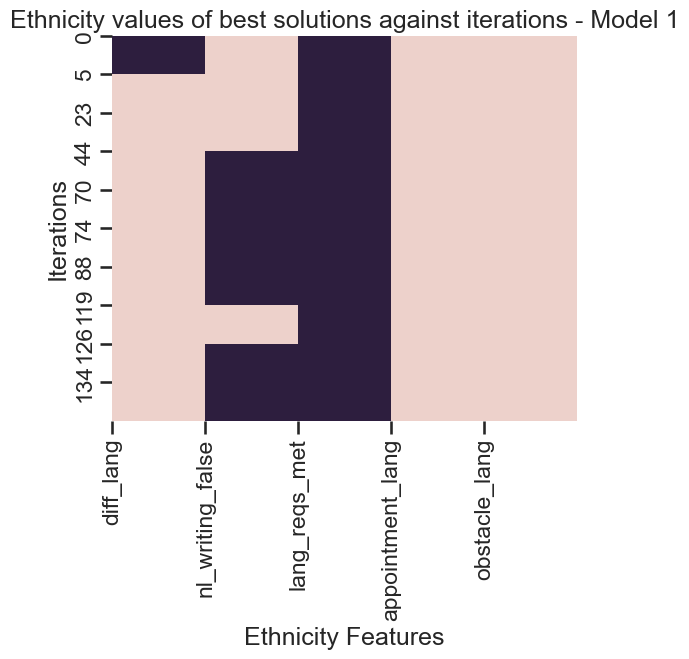

In [436]:
# Create heatmap with on y-axis all ethnicity features and on x-axis 10 random iterations selected (but always including first)

# Get 10 random indices to display on x-axis
random_iterations = np.concatenate(([0], np.random.choice(count - 1, 9, replace=False)))
random_iterations.sort()
print(random_iterations)

selected_ethnic_vals = np.array(best_fitness_ethnic_vls)[random_iterations].transpose()
print(selected_ethnic_vals)

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(selected_ethnic_vals.transpose(), cmap=sns.cubehelix_palette(as_cmap=True), cbar=False)
# Label the y-axis with the selected random iterations, but only label every 5th iteration
# plt.yticks(ticks=np.arange(start=0, stop=random_iterations[count-1], step=5), labels=[str(i) for i in random_iterations])
plt.yticks(ticks=range(0, 10), labels=[str(i) for i in random_iterations])
# Label the x-axis with the 5 ethnicity feature names, but vertically (rotate by 90 deg and center)
plt.xticks(ticks=range(0, 5), labels=[str(feat) for feat in ethnicity_features_en], rotation=90, ha='center')
plt.ylabel("Iterations")
plt.xlabel("Ethnicity Features")
plt.title("Ethnicity values of best solutions against iterations - Model 1")
plt.show()